<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

2024-12-11 17:21:07.488388: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 17:21:07.511510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733934067.520180 3417797 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733934067.522855 3417797 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 17:21:07.531989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

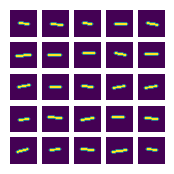

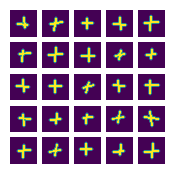

In [9]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [10]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #7580

X_text: "37+90" = y_text: "127"


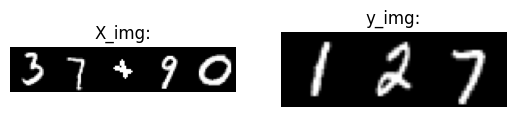

Query #5918

X_text: "29+59" = y_text: "88 "


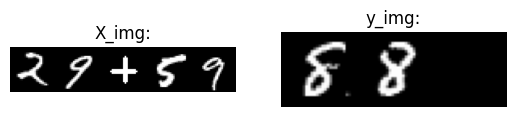

Query #4872

X_text: "24+36" = y_text: "60 "


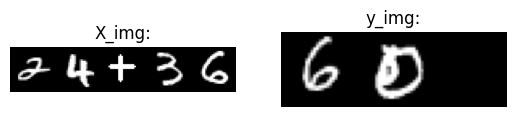

Query #1107

X_text: "5-53 " = y_text: "-48"


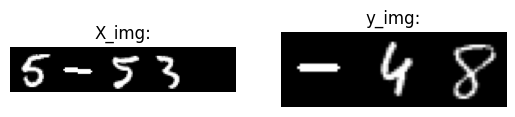

Query #5520

X_text: "27+60" = y_text: "87 "


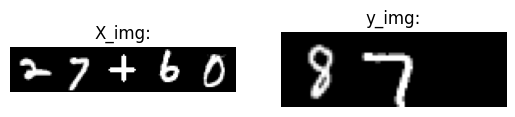

Query #4979

X_text: "24-89" = y_text: "-65"


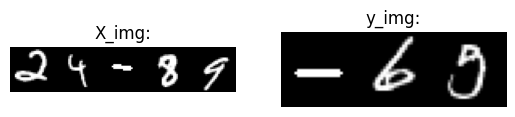

Query #6813

X_text: "34-6 " = y_text: "28 "


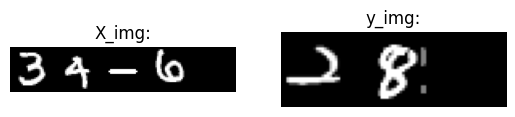

Query #1289

X_text: "6-44 " = y_text: "-38"


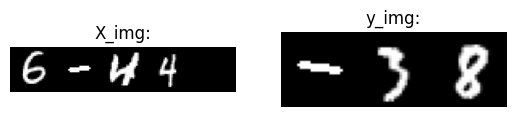

Query #3583

X_text: "17-91" = y_text: "-74"


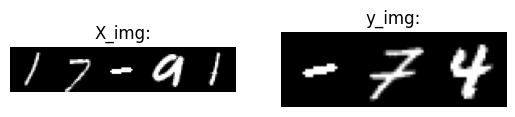

Query #1125

X_text: "5-62 " = y_text: "-57"


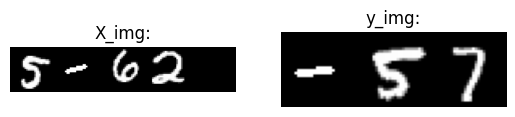

In [11]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [14]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

X_text_onehot_train, X_text_onehot_test, y_text_onehot_train, y_text_onehot_test = train_test_split(
    X_text_onehot, y_text_onehot, test_size=0.1, random_state=42
)
print("X_text_onehot_train shape:", X_text_onehot_train.shape)
print("y_text_onehot_train shape:", y_text_onehot_train.shape)
print("X_text_onehot_test shape:", X_text_onehot_test.shape)
print("y_text_onehot_test shape:", y_text_onehot_test.shape)

(20000, 5, 13) (20000, 3, 13)
X_text_onehot_train shape: (18000, 5, 13)
y_text_onehot_train shape: (18000, 3, 13)
X_text_onehot_test shape: (2000, 5, 13)
y_text_onehot_test shape: (2000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [13]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [16]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## Your first task is to fit the text2text model using X_text and y_text)

# Build the model
model = build_text2text_model()

# Train the model
history = model.fit(
    X_text_onehot_train, y_text_onehot_train,
    validation_data=(X_text_onehot_test, y_text_onehot_test),
    epochs=40, batch_size=64, verbose=1
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_text_onehot_test, y_text_onehot_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3159 - loss: 2.0803 - val_accuracy: 0.4340 - val_loss: 1.5646
Epoch 2/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4579 - loss: 1.5012 - val_accuracy: 0.4887 - val_loss: 1.3629
Epoch 3/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5283 - loss: 1.2966 - val_accuracy: 0.5120 - val_loss: 1.2782
Epoch 4/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5649 - loss: 1.1946 - val_accuracy: 0.5897 - val_loss: 1.1264
Epoch 5/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5963 - loss: 1.1062 - val_accuracy: 0.6062 - val_loss: 1.0666
Epoch 6/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6113 - loss: 1.0591 - val_accuracy: 0.6258 - val_loss: 1.0088
Epoch 7/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6253 - loss: 1.0090 - val_accuracy: 0.6245 - val_loss: 0.9952
Epoch 8/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6467 - loss: 0.9527 - val_accuracy: 0.


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
## Your code





---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [18]:
# Your code
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.models import Model

def build_text2image_model():
    # Input: Text query (batch_size, max_query_length, num_characters)
    text_input = Input(shape=(max_query_length, len(unique_characters)), name="Text_Input")

    # RNN for text encoding
    text_encoder = LSTM(256)(text_input)
    latent_representation = Dense(128, activation="relu")(text_encoder)

    # Repeat latent representation for each output image
    repeated_latent = RepeatVector(max_answer_length)(latent_representation)

    # RNN for sequence decoding
    image_decoder = LSTM(256, return_sequences=True)(repeated_latent)
    dense_decoder = TimeDistributed(Dense(7 * 7 * 128, activation="relu"))(image_decoder)
    
    # CNN decoder to generate images
    cnn_decoder = TimeDistributed(
        tf.keras.Sequential(
            [
                Reshape((7, 7, 128)),
                Conv2DTranspose(64, (3, 3), strides=(2, 2), activation="relu", padding="same"),
                Conv2DTranspose(1, (3, 3), strides=(2, 2), activation="sigmoid", padding="same"),
            ]
        )
    )(dense_decoder)

    # Define the model
    model = Model(inputs=text_input, outputs=cnn_decoder)
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    model.summary()

    return model


# Build the text-to-image model
text2image_model = build_text2image_model()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Text_Input (InputLayer)         │ (None, 5, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 3, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 3, 28, 28, 1)   │        74,369 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,389,889 (9.12 MB)

 Trainable params: 2,389,889 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Split data into training and testing sets
X_text_train, X_text_test, y_img_train, y_img_test = train_test_split(
    X_text_onehot, y_img, test_size=0.1, random_state=42
)

# Train the model
history = text2image_model.fit(
    X_text_train,
    y_img_train,
    validation_data=(X_text_test, y_img_test),
    epochs=50,
    batch_size=64,
)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8567 - loss: 0.1038 - val_accuracy: 0.8659 - val_loss: 0.0544
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8658 - loss: 0.0539 - val_accuracy: 0.8650 - val_loss: 0.0519
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8655 - loss: 0.0508 - val_accuracy: 0.8648 - val_loss: 0.0486
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8652 - loss: 0.0480 - val_accuracy: 0.8646 - val_loss: 0.0479
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8637 - loss: 0.0476 - val_accuracy: 0.8639 - val_loss: 0.0472
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8637 - loss: 0.0468 - val_accuracy: 0.8635 - val_loss: 0.0469
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8631 - loss: 0.0464 - val_accuracy: 0.8627 - val_loss: 0.0462
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8632 - loss: 0.0461 - val_accura

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8576 - loss: 0.0391
Test Loss: 0.03927914798259735, Test Accuracy: 0.8573448061943054
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


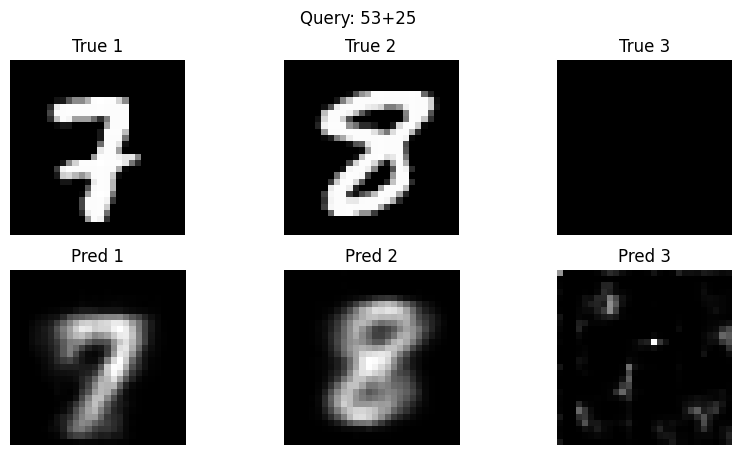

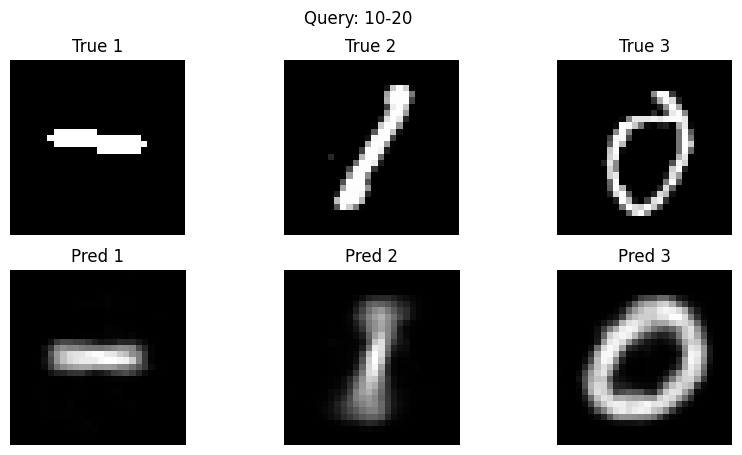

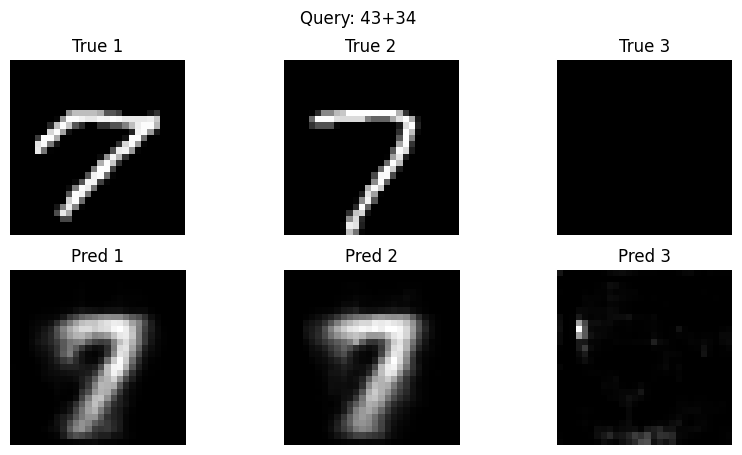

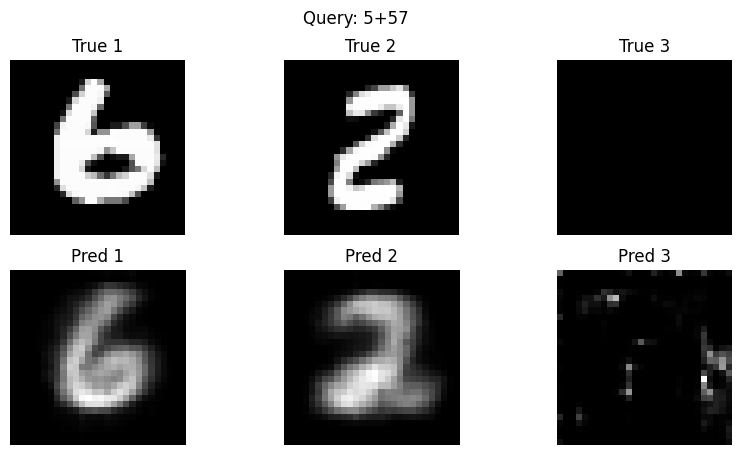

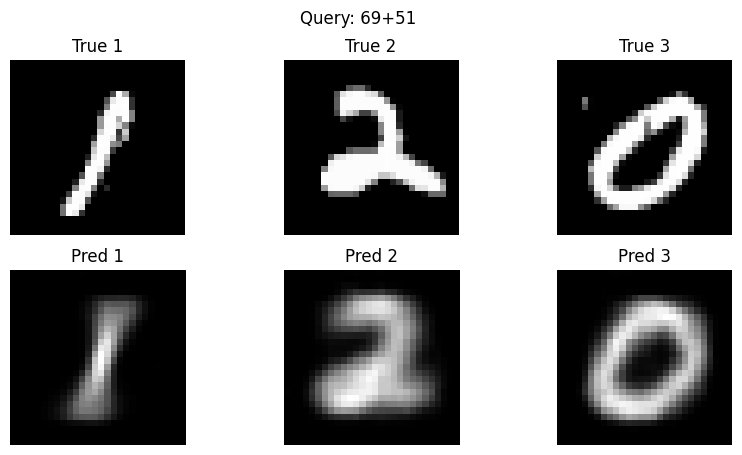

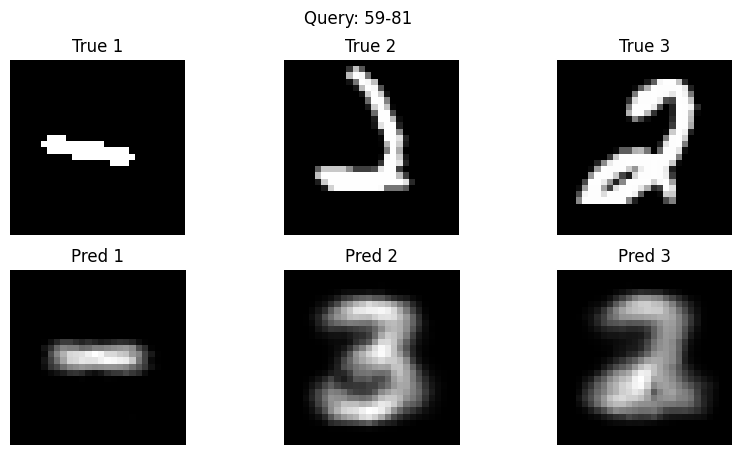

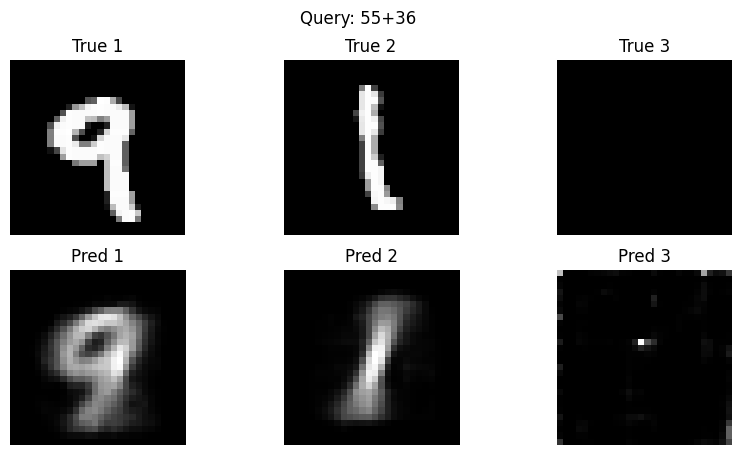

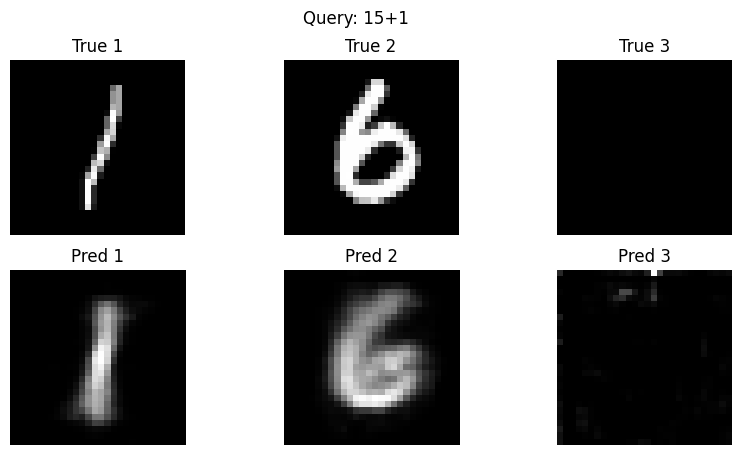

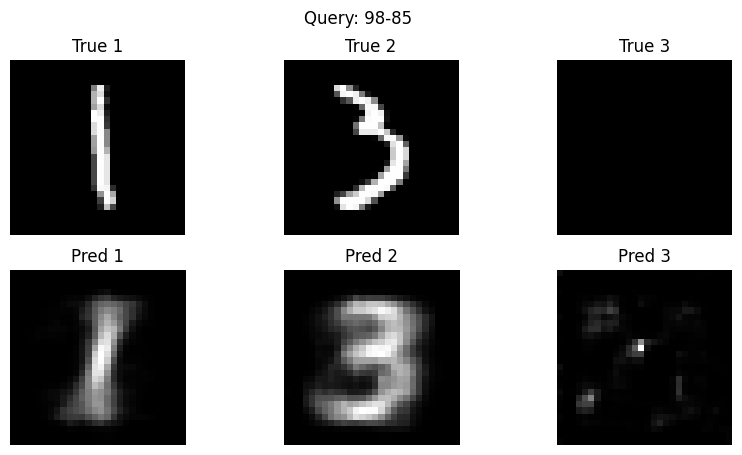

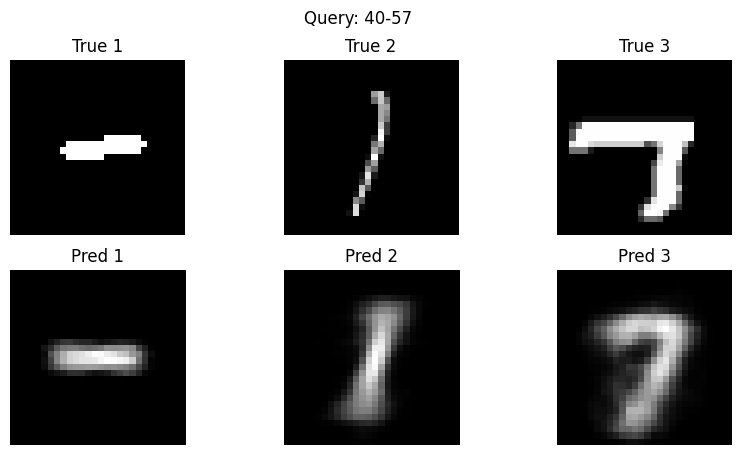

In [20]:
# Evaluate the model
test_loss, test_accuracy = text2image_model.evaluate(X_text_test, y_img_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict on test samples
y_pred = text2image_model.predict(X_text_test)

# Visualize generated images
def visualize_generated_images(n=5):
    for i in range(n):
        plt.figure(figsize=(10, 5))
        plt.suptitle(f"Query: {decode_labels(X_text_test[i])}")
        for j in range(max_answer_length):
            plt.subplot(2, max_answer_length, j + 1)
            plt.imshow(y_img_test[i][j], cmap="gray")
            plt.axis("off")
            plt.title(f"True {j+1}")

            plt.subplot(2, max_answer_length, max_answer_length + j + 1)
            plt.imshow(y_pred[i][j], cmap="gray")
            plt.axis("off")
            plt.title(f"Pred {j+1}")
        plt.show()

# Visualize a few examples
visualize_generated_images(n=10)

In [21]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

def build_text2image_model_2():
    text_input = Input(shape=(max_query_length, len(unique_characters)), name="Text_Input")

    # RNN Encoder with stacked LSTMs
    # First LSTM layer returns sequences so the second LSTM can process them
    text_encoder_1 = LSTM(256, return_sequences=True)(text_input)
    text_encoder_2 = LSTM(256, return_sequences=True)(text_encoder_1)  # Second LSTM consumes the sequence
    text_encoder_3 = LSTM(256)(text_encoder_2)  # Third LSTM consumes the sequence

    latent_representation = Dense(128, activation="relu")(text_encoder_3)

    # Repeat latent representation for each output image
    repeated_latent = RepeatVector(max_answer_length)(latent_representation)

    # RNN Decoder
    image_decoder = LSTM(256, return_sequences=True)(repeated_latent)
    dense_decoder = TimeDistributed(Dense(7 * 7 * 128, activation="relu"))(image_decoder)
    
    # CNN decoder to generate images
    cnn_decoder = TimeDistributed(
        tf.keras.Sequential(
            [
                Reshape((7, 7, 128)),
                Conv2DTranspose(64, (3, 3), strides=(2, 2), activation="relu", padding="same"),
                Conv2DTranspose(1, (3, 3), strides=(2, 2), activation="sigmoid", padding="same"),
            ]
        )
    )(dense_decoder)

    # Define the model
    model = Model(inputs=text_input, outputs=cnn_decoder)
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    model.summary()

    return model


# Build the modified text-to-image model with deeper encoder
text2image_model_2 = build_text2image_model_2()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Text_Input (InputLayer)         │ (None, 5, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 5, 256)         │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 5, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 3, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 3, 6272)        │     1,611,904 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 3, 28, 28, 1)   │        74,369 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,440,513 (13.12 MB)

 Trainable params: 3,440,513 (13.12 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Split data into training and testing sets
X_text_train, X_text_test, y_img_train, y_img_test = train_test_split(
    X_text_onehot, y_img, test_size=0.1, random_state=42
)

# Train the model
history = text2image_model_2.fit(
    X_text_train,
    y_img_train,
    validation_data=(X_text_test, y_img_test),
    epochs=50,
    batch_size=64,
)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8551 - loss: 0.1071 - val_accuracy: 0.8653 - val_loss: 0.0545
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8658 - loss: 0.0542 - val_accuracy: 0.8657 - val_loss: 0.0544
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8657 - loss: 0.0541 - val_accuracy: 0.8659 - val_loss: 0.0544
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8656 - loss: 0.0542 - val_accuracy: 0.8658 - val_loss: 0.0544
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8652 - loss: 0.0534 - val_accuracy: 0.8654 - val_loss: 0.0491
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8656 - loss: 0.0482 - val_accuracy: 0.8651 - val_loss: 0.0473
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8648 - loss: 0.0473 - val_accuracy: 0.8640 - val_loss: 0.0470
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8640 - loss: 0.0468 - val_accu

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8608 - loss: 0.0428
Test Loss: 0.04299883171916008, Test Accuracy: 0.8603823184967041
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


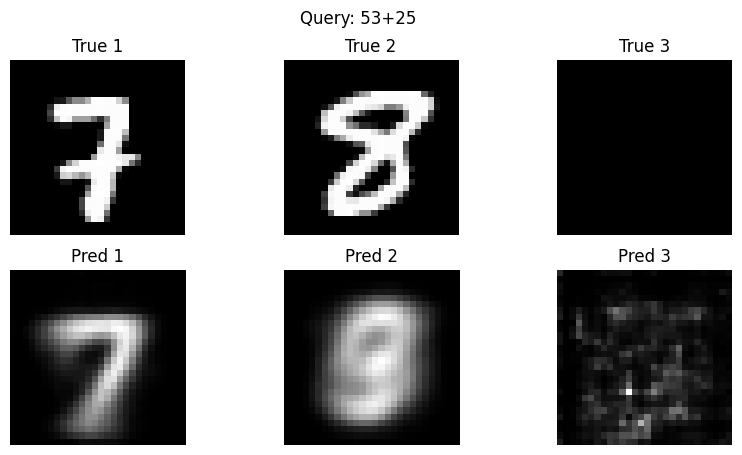

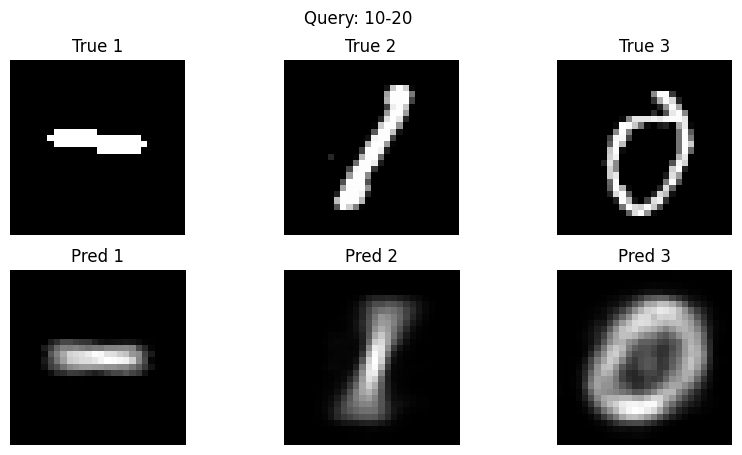

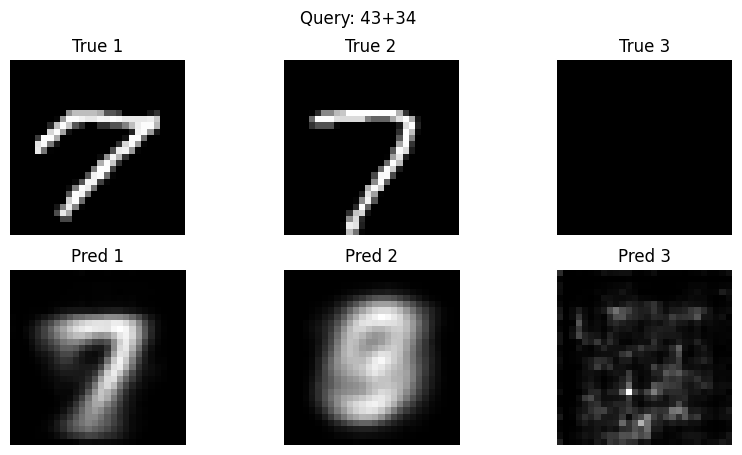

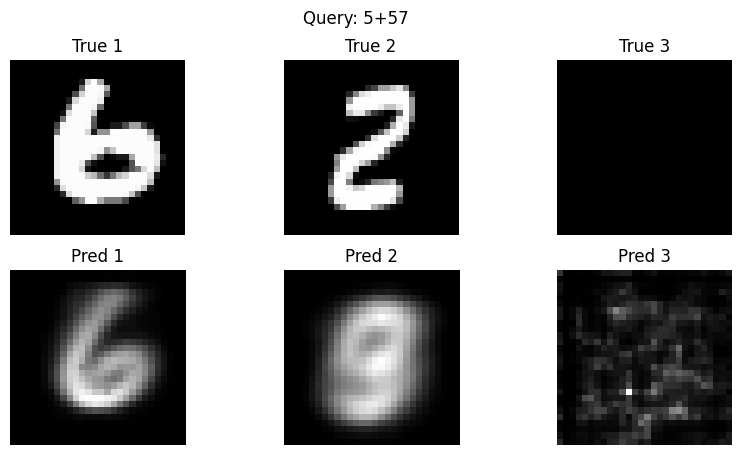

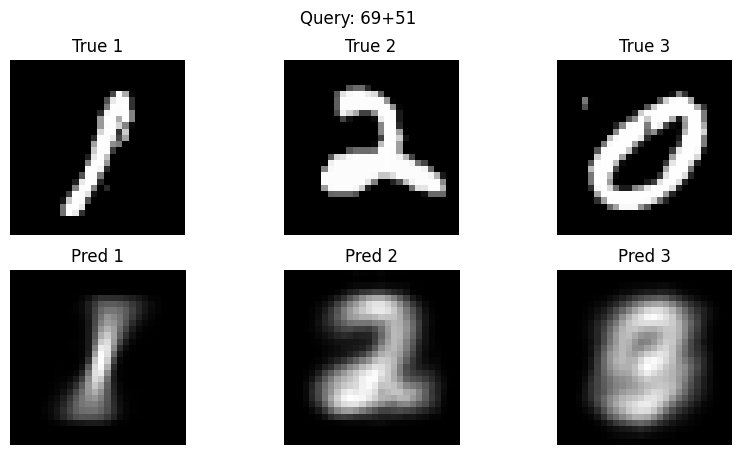

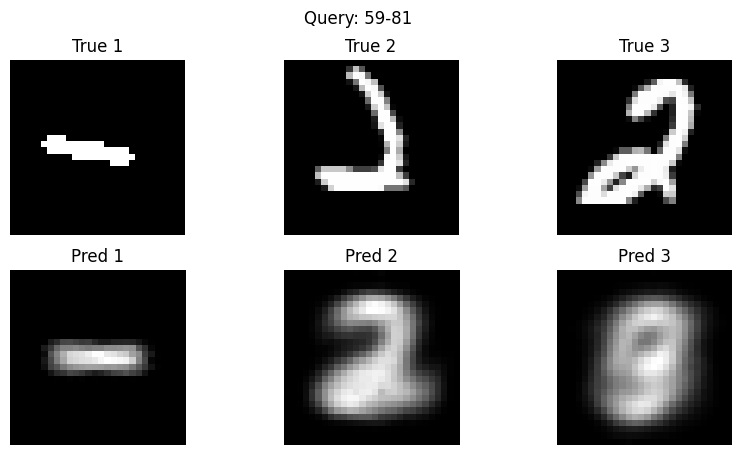

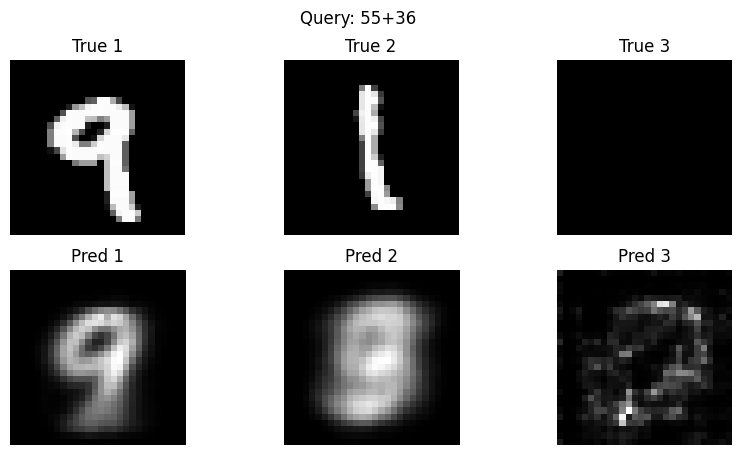

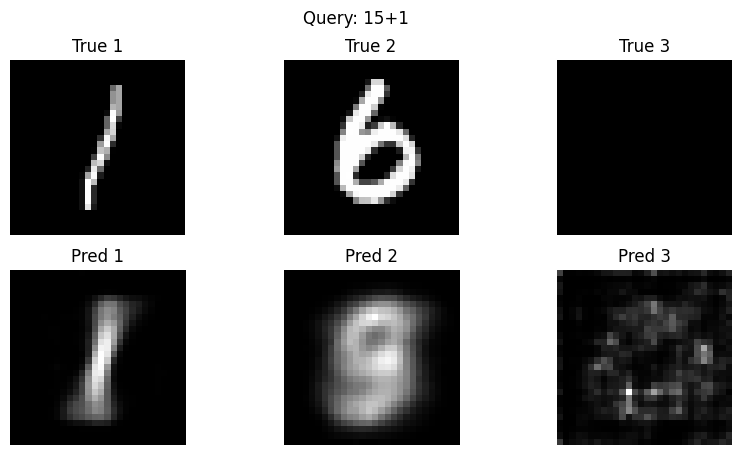

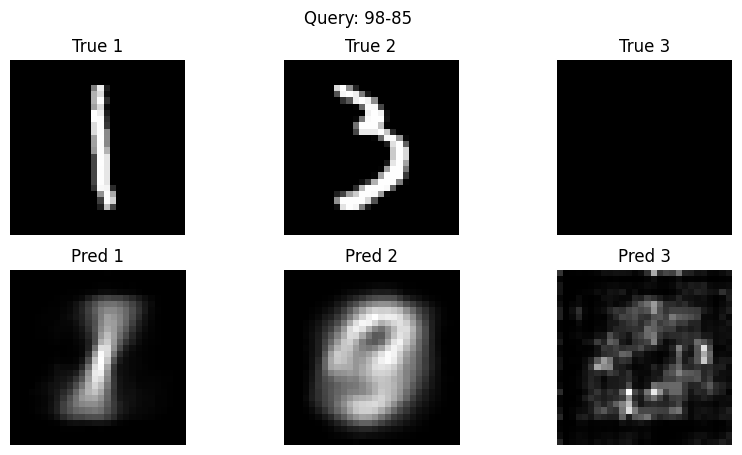

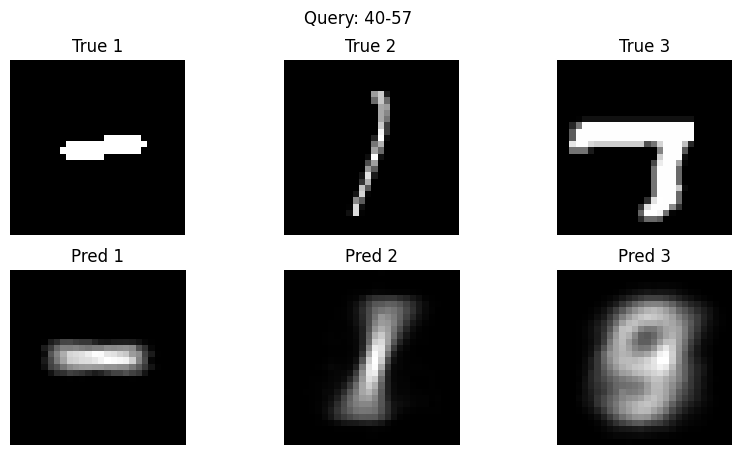

In [23]:
# Evaluate the model
test_loss, test_accuracy = text2image_model_2.evaluate(X_text_test, y_img_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict on test samples
y_pred = text2image_model_2.predict(X_text_test)

# Visualize generated images
def visualize_generated_images(n=5):
    for i in range(n):
        plt.figure(figsize=(10, 5))
        plt.suptitle(f"Query: {decode_labels(X_text_test[i])}")
        for j in range(max_answer_length):
            plt.subplot(2, max_answer_length, j + 1)
            plt.imshow(y_img_test[i][j], cmap="gray")
            plt.axis("off")
            plt.title(f"True {j+1}")

            plt.subplot(2, max_answer_length, max_answer_length + j + 1)
            plt.imshow(y_pred[i][j], cmap="gray")
            plt.axis("off")
            plt.title(f"Pred {j+1}")
        plt.show()

# Visualize a few examples
visualize_generated_images(n=10)